In [112]:
from load_dataset import load_dataset
from describe_dataset import describe
import matplotlib.pyplot as plt
import numpy as np
from d3rlpy.dataset import MDPDataset

In [37]:
teleop_dataset = load_dataset("data/teleop_1000.h5")
buffer_1 = load_dataset("data/buffer_1.pkl")

In [38]:
teleop_returns = np.array([e.compute_return() for e in teleop_dataset.episodes])
buffer1_returns = np.array([e.compute_return() for e in buffer_1.episodes])

# Generate sub-buffers according to trajectories quality

Total returns > 0: 966
Total returns < 0: 34


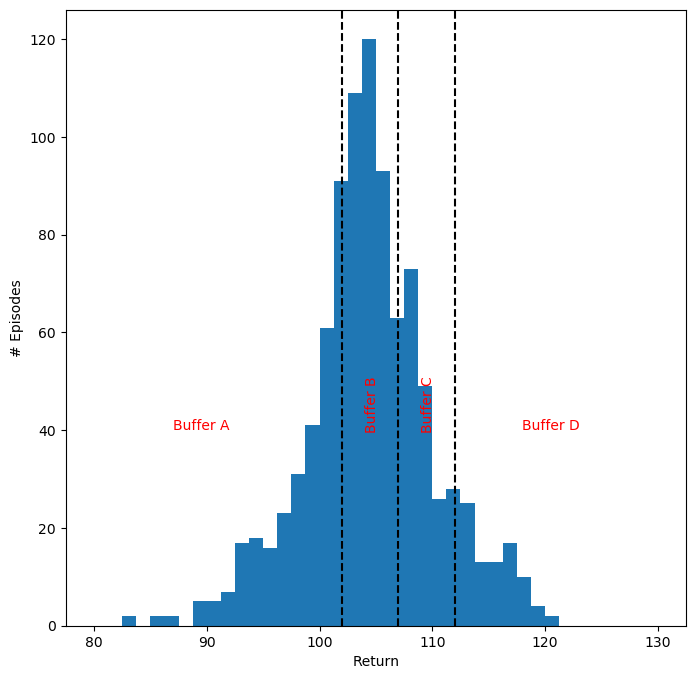

In [109]:
range_start = 80
range_end = 130
threshold_a = 102
threshold_b = 107
threshold_c = 112
plt.figure(figsize=(8, 8))
plt.hist(teleop_returns, bins=40, range=(range_start, range_end))
plt.axvline(x=threshold_a, color="k", linestyle="--")
plt.axvline(x=threshold_b, color="k", linestyle="--")
plt.axvline(x=threshold_c, color="k", linestyle="--")
plt.text(x=(range_start + threshold_a)/2 - 4, y=40, s="Buffer A", color='red')
plt.text(x=(threshold_a + threshold_b)/2 - 0.5, y=40, s="Buffer B", rotation=90, color='red')
plt.text(x=(threshold_b + threshold_c)/2 - 0.5, y=40, s="Buffer C", rotation=90, color='red')
plt.text(x=(threshold_c + range_end)/2 - 3, y=40, s="Buffer D", color='red')
plt.ylabel("# Episodes")
plt.xlabel("Return")
print(f"Total returns > 0:", np.sum(teleop_returns > 0))
print(f"Total returns < 0:", np.sum(teleop_returns < 0))

In [103]:
# get only good
split_buffers = {
    "A": {
        "range": (-1e5, threshold_a),
        "episodes": []
    },
    "B": {
        "range": (threshold_a, threshold_b),
        "episodes": []
    },
    "C": {
        "range": (threshold_b, threshold_c),
        "episodes": []
    },
    "D": {
        "range": (threshold_c, 1e5),
        "episodes": []
    }
}
for episode in teleop_dataset.episodes:
    ret = episode.compute_return()
    for buffer_name in split_buffers.keys():
        buffer_ret_range = split_buffers[buffer_name]["range"]
        if ret >= buffer_ret_range[0] and ret < buffer_ret_range[1]:
            split_buffers[buffer_name]["episodes"].append(episode)

In [174]:
# describe
for buffer_name, buffer_data in split_buffers.items():
    range_ = buffer_data["range"]
    buffer_returns = np.array([e.compute_return() for e in buffer_data["episodes"]])
    avg_return = np.mean(buffer_returns)
    print(f"Buffer {buffer_name} between {min(buffer_returns):.2f} to {max(buffer_returns):.2f} contains {len(buffer_data['episodes'])} ({100 * len(buffer_data['episodes'])/len(teleop_dataset) :.2f}%) episodes with average return {avg_return:.2f}")

Buffer A between -534.77 to 101.95 contains 318 (31.80%) episodes with average return 40.92
Buffer B between 102.01 to 106.99 contains 401 (40.10%) episodes with average return 104.35
Buffer C between 107.02 to 111.99 contains 191 (19.10%) episodes with average return 109.10
Buffer D between 112.25 to 120.15 contains 90 (9.00%) episodes with average return 115.29


In [178]:

for buffer_name, buffer_data in split_buffers.items():
    print(f"Generating subuffer {buffer_name}")
    observations = []
    rewards = []
    actions = []
    terminals = []
    for i, episode in enumerate(buffer_data["episodes"]):
        observations.append(episode.observations)
        rewards.append(episode.rewards)
        actions.append(episode.actions)
        term_array = np.zeros(shape=(len(episode.rewards)))
        term_array[-1] = episode.terminal
        terminals.append(term_array)
    subbuffer = MDPDataset(observations=np.concatenate(observations),
                           actions=np.concatenate(actions), 
                           rewards=np.concatenate(rewards), 
                           terminals=np.concatenate(terminals))
    subbuffer_returns = np.array([e.compute_return() for e in subbuffer])
    avg_return = np.mean(subbuffer_returns)
    output_name = f"data/teleop_subbuffer_{buffer_name}.h5"
    subbuffer.dump(output_name)
    print(f"Avg return: {avg_return:.2f}. Exported to {output_name}")

Generating subuffer A
Avg return: 40.92. Exported to data/teleop_subbuffer_A.h5
Generating subuffer B
Avg return: 104.35. Exported to data/teleop_subbuffer_B.h5
Generating subuffer C
Avg return: 109.10. Exported to data/teleop_subbuffer_C.h5
Generating subuffer D
Avg return: 115.29. Exported to data/teleop_subbuffer_D.h5
